Prefix-Tuning 必须在 Attention 层，注入可学习的 Key / Value

In [65]:
import torch
import torch.nn as nn
from transformers.models.bert.modeling_bert import BertSelfAttention
from transformers import BertForSequenceClassification


In [66]:
class PrefixSelfAttention(BertSelfAttention):
    def __init__(self, config, prefix_len):
        super().__init__(config)

        self.prefix_len = prefix_len
        self.num_heads = config.num_attention_heads
        self.head_dim = config.hidden_size // self.num_heads
        self.all_head_size = self.num_heads * self.head_dim

        self.prefix_key = nn.Parameter(torch.randn(1, self.num_heads, prefix_len, self.head_dim) * 0.02)
        self.prefix_value = nn.Parameter(torch.randn(1, self.num_heads, prefix_len, self.head_dim) * 0.02)


    def _transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_heads, self.head_dim)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(self, hidden_states, attention_mask=None, *args, **kwargs):
        query = self._transpose_for_scores(self.query(hidden_states))
        key = self._transpose_for_scores(self.key(hidden_states))
        value = self._transpose_for_scores(self.value(hidden_states))

        batch_size = hidden_states.size(0)

        prefix_k = self.prefix_key.expand(batch_size, -1, -1, -1)
        prefix_v = self.prefix_value.expand(batch_size, -1, -1, -1)

        key = torch.cat([prefix_k, key], dim=2)
        value = torch.cat([prefix_v, value], dim=2)

        attention_scores = torch.matmul(query, key.transpose(-1, -2))
        attention_scores = attention_scores / (self.head_dim ** 0.5)

        if attention_mask is not None:
            attention_scores = attention_scores + attention_mask

        attention_probs = nn.functional.softmax(attention_scores, dim=-1)

        context_layer = torch.matmul(attention_probs, value)

        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        context_layer = context_layer.view(
            batch_size, -1, self.all_head_size
        )

        # ⚠️ 关键：必须返回两个值
        return (context_layer, attention_probs)

In [67]:
def inject_prefix_bert(model, prefix_len=5):
    for layer in model.bert.encoder.layer:
        layer.attention.self = PrefixSelfAttention(
            model.config,
            prefix_len=prefix_len
        )

In [68]:
from transformers import BertTokenizer
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

In [69]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = BertTokenizer.from_pretrained("../bert-base-uncased")

def prepare_data(texts, labels):
    enc = tokenizer(
        texts,
        padding=True,
        truncation=True,
        return_tensors="pt"
    )
    return TensorDataset(
        enc["input_ids"],
        enc["attention_mask"],
        torch.tensor(labels)
    )

texts = [
    "Prefix tuning works well.",
    "This approach is ineffective."
]
labels = [1, 0]

dataset = prepare_data(texts, labels)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

model = BertForSequenceClassification.from_pretrained(
    "../bert-base-uncased",
    num_labels=2
)

# === 注入 Prefix ===
inject_prefix_bert(model, prefix_len=20)
model.to(device)

# === 冻结 BERT encoder（非常关键）===
for name, param in model.named_parameters():
    if "prefix" not in name and "classifier" not in name:
        param.requires_grad = False

# === Optimizer ===
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-4,
    weight_decay=1e-2
)

criterion = nn.CrossEntropyLoss()


Loading weights: 100%|██████████| 199/199 [00:00<00:00, 553.14it/s, Materializing param=bert.pooler.dense.weight]                               
BertForSequenceClassification LOAD REPORT from: ../bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those

In [72]:
loss_history = []

for epoch in range(100):
    model.train()
    total_loss = 0.0

    for batch in dataloader:
        input_ids, attention_mask, labels = [
            b.to(device) for b in batch
        ]

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        loss = criterion(outputs.logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    loss_history.append(avg_loss)

    print(f"Epoch {epoch+1:02d} | Loss: {avg_loss:.4f}")


Epoch 01 | Loss: 0.6835
Epoch 02 | Loss: 0.8242
Epoch 03 | Loss: 0.7282
Epoch 04 | Loss: 0.6038
Epoch 05 | Loss: 0.6788
Epoch 06 | Loss: 0.6377
Epoch 07 | Loss: 0.7769
Epoch 08 | Loss: 0.5955
Epoch 09 | Loss: 0.7772
Epoch 10 | Loss: 0.8509
Epoch 11 | Loss: 0.6761
Epoch 12 | Loss: 0.6220
Epoch 13 | Loss: 0.5992
Epoch 14 | Loss: 0.8418
Epoch 15 | Loss: 0.8372
Epoch 16 | Loss: 0.6774
Epoch 17 | Loss: 0.6958
Epoch 18 | Loss: 0.6768
Epoch 19 | Loss: 0.5154
Epoch 20 | Loss: 0.6274
Epoch 21 | Loss: 0.6582
Epoch 22 | Loss: 0.6337
Epoch 23 | Loss: 0.6668
Epoch 24 | Loss: 0.7040
Epoch 25 | Loss: 0.5903
Epoch 26 | Loss: 0.6439
Epoch 27 | Loss: 0.6869
Epoch 28 | Loss: 0.5465
Epoch 29 | Loss: 0.7644
Epoch 30 | Loss: 0.7573
Epoch 31 | Loss: 0.5628
Epoch 32 | Loss: 0.6894
Epoch 33 | Loss: 0.6533
Epoch 34 | Loss: 0.8062
Epoch 35 | Loss: 0.5291
Epoch 36 | Loss: 0.5633
Epoch 37 | Loss: 0.6166
Epoch 38 | Loss: 0.7561
Epoch 39 | Loss: 0.8125
Epoch 40 | Loss: 0.7550
Epoch 41 | Loss: 0.6885
Epoch 42 | Loss:

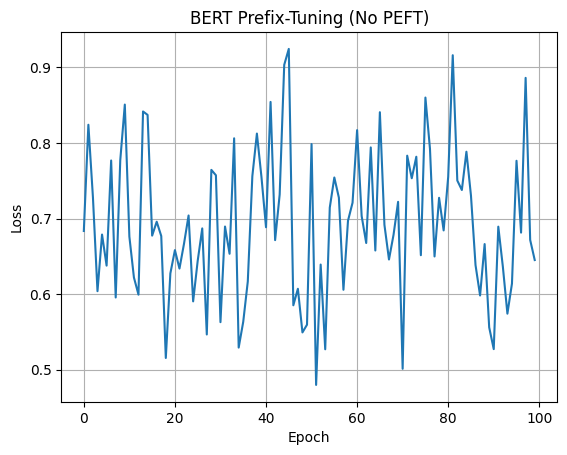

In [73]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("BERT Prefix-Tuning (No PEFT)")
plt.grid(True)
plt.show()